In [1]:
import os
import datetime

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers

import dataset

In [2]:
MAXLEN = 60
BATCH_SIZE = 32
files = ['texts/' + f for f in os.listdir('texts/') if not f.startswith('.')]

data = dataset.load_file(BATCH_SIZE, 0.05, maxlen=MAXLEN, filenames=files)

In [36]:
EMBED_DIM = 512
UNITS = 316

common_input = tf.keras.Input(batch_shape=(None, data.input_texts.shape[1]), batch_size=BATCH_SIZE)
common = layers.Embedding(len(data.letters_table), EMBED_DIM, mask_zero=True)(common_input)
common = layers.Bidirectional(layers.GRU(UNITS, return_sequences=True, dropout=0.3), merge_mode='sum', name='Common_RNN')(common)

common = layers.add([common, layers.Bidirectional(layers.GRU(UNITS, return_sequences=True, dropout=0.1), merge_mode='sum', name='Dagesh_RNN')(common)])

niqqud = layers.Softmax(name='N')(layers.Dense(data.niqqud_texts.shape[1])(common))
dagesh = layers.Softmax(name='D')(layers.Dense(data.dagesh_texts.shape[1])(common))

model = tf.keras.Model(inputs=[common_input], outputs=[niqqud, dagesh])

tf.keras.utils.plot_model(model, to_file='model.png')
model.summary()

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.
Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding_18 (Embedding)        (None, 60, 512)      37376       input_19[0][0]                   
__________________________________________________________________________________________________
Common_RNN (Bidirectional)      (None, 60, 316)      1573680     embedding_18[0][0]               
__________________________________________________________________________________________________
Dagesh_RNN (Bidirectional)      (None, 60, 316)      1202064     Common_RNN[0][0]                 
_____

In [37]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

def fit(learning_rates):
    return model.fit(data.input_texts, [data.niqqud_texts, data.dagesh_texts],
          batch_size=BATCH_SIZE,
          epochs=len(learning_rates),
          validation_data=(data.input_validation, [data.niqqud_validation,  data.dagesh_validation]),
          callbacks=[
              tf.keras.callbacks.LearningRateScheduler(lambda epoch, lr: learning_rates[epoch], verbose=0),
              # tf.keras.callbacks.ModelCheckpoint(filepath='checkpoints/ckpt_{epoch}', save_weights_only=True),
          ]
    )

In [ ]:
history = fit([2e-3, 7e-4]) #, 1e-4, 3e-6])

Train on 111720 samples, validate on 5880 samples
Epoch 1/2
111720/111720 [==============================] - 149s 1ms/sample - loss: 0.2957 - N_loss: 0.2334 - D_loss: 0.0623 - N_accuracy: 0.9205 - D_accuracy: 0.9769 - val_loss: 0.1777 - val_N_loss: 0.1385 - val_D_loss: 0.0391 - val_N_accuracy: 0.9539 - val_D_accuracy: 0.9855
Epoch 2/2
 65440/111720 [================>.............] - ETA: 56s - loss: 0.1461 - N_loss: 0.1129 - D_loss: 0.0333 - N_accuracy: 0.9621 - D_accuracy: 0.9875

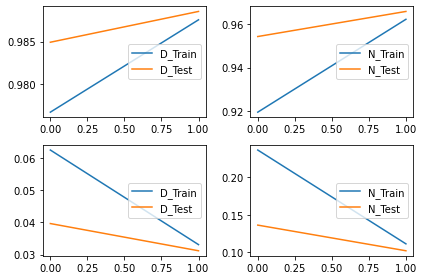

In [31]:
fig, ax = plt.subplots(nrows=2, ncols=2)

for n, v in enumerate(['accuracy', 'loss'], 0):
    for n1, t in enumerate(['D', 'N'], 0):
        p = ax[n][n1]
        p.plot(history.history[t + '_' + v][0:])
        p.plot(history.history['val_' + t + '_' +  v][0:])
        p.legend([t + '_Train', t + '_Test'], loc='center right')

plt.tight_layout()

In [9]:
def print_predictions(k):
    s = slice(k*BATCH_SIZE, (k+1)*BATCH_SIZE)
    batch = data.input_validation[s]
    [actual_niqqud, actual_dagesh] = dataset.from_categorical(model.predict(batch))
    [expected_niqqud, expected_dagesh] = [data.niqqud_validation[s], data.dagesh_validation[s]]
    actual = data.merge(batch, ns=actual_niqqud, ds=actual_dagesh)
    expected = data.merge(batch, ns=expected_niqqud, ds=expected_dagesh)
    for i, (a, e) in enumerate(zip(actual, expected)):
        print('מצוי: ', a)
        print('רצוי: ', e)
        print()

print_predictions(8)

מצוי:  הַנִּשְרָפִין, בַּחוּץ אוֹ לְמָחָר--הֲרֵי הֶן כְּשֵרִים. וְכֵן כָּל כַּיּוֹצֶא בְּזֶה. [ט]
רצוי:  הַנִּשְרָפִין, בַּחוּץ אוֹ לְמָחָר--הֲרֵי הֶן כְּשֵרִים. וְכֵן כָּל כַּיּוֹצֶא בְּזֶה. [ט]

מצוי:  שֶלֹּא לְהַקְרִיב בַּעַל מוּם מִיַּד הַגּוֹיִים, שֶנֶּאֱמָר "וּמִיַּד בֶּן-נֵכָר, לֹא
רצוי:  שֶלֹּא לְהַקְרִיב בַּעַל מוּם מִיַּד הַגּוֹיִים, שֶנֶּאֱמָר "וּמִיַּד בֶּן-נֵכָר, לֹא

מצוי:  שֶיִּהְיֶה הַמִּין שְהֶן שֻתָּפִין בּוֹ, מִין אֶחָד וּבִכְלִי אֶחָד; אֲבָל אִם הָיָה אֶחָד
רצוי:  שֶיִּהְיֶה הַמִּין שְהֶן שֻתָּפִין בּוֹ, מִין אֶחָד וּבִכְלִי אֶחָד; אֲבָל אִם הָיָה אֶחָד

מצוי:  הַסִפּוּן, שוּם דָּבָר שֶבָּעוֹלָם לֹא יָנִיא אוֹתִי לְטְפֵּס שוּב בְּמַעֲלָה סֻלָּם-חֲבָלִים
רצוי:  הַסִפּוּן, שוּם דָבָר שֶבָּעוֹלָם לֹא יָנִיא אוֹתִי לְטַפֵּס שוּב בְּמַעֲלֵה סֻלַם-חֲבָלִים

מצוי:  הַדָּמִים. מָכַר הַלּוֹקֵחַ בָּשָר זֶה שֶלִּטְרֵפָה לַגּוֹיִים, אוֹ שֶהֶאֱכִילוּ
רצוי:  הַדָּמִים. מָכַר הַלּוֹקֵחַ בָּשָר זֶה שֶלִּטְרֵפָה לַגּוֹיִים, אוֹ שֶהֶאֱכִילוֹ

מצוי:  וּבַמַּעַשְרוֹת, וְאֵיזֶה דָּבָר פ